In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Filter out some values where number of datapoints are pretty low.
countDF = velGmagDF.groupby([ "normMLT", "MLAT" ]).size().reset_index()
countDF.columns = [ "normMLT", "MLAT", "count" ]
# Choose only columns which have atleast 100 points
countDF = countDF[ countDF["count"] >= numPointsCutoffMLTMLAT ].reset_index(drop=True)
# Merge with velsDataDF to filter out unwanted values
velGmagDF = pandas.merge( velGmagDF, countDF,\
                          on=["normMLT", "MLAT"], how='inner' )
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count
0,-4.0,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",731,-575,-210,156,0,2677
1,-4.0,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",651,-524,-199,127,2,2677
2,-4.0,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",586,-470,-177,116,4,2677
3,-4.0,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",562,-418,-137,144,6,2677
4,-4.0,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",569,-450,-166,119,8,2677


In [10]:
# Create AU bins
alBins = [ -1600, -1000, -500, 0, 100 ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["AL"], \
                               bins=alBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps", "azim",\
                         "vMagnErr", "azimErr", "dtStr", "tmStr",\
                         "date", "hour", "dst_date",\
                         "dst_index", "dst_bin", \
                         "AE", "AL", "AO", "AU", "minute", "count","AL_bin"]
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count,AL_bin
0,-4.0,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",731,-575,-210,156,0,2677,"(-1000, -500]"
1,-4.0,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",651,-524,-199,127,2,2677,"(-1000, -500]"
2,-4.0,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",586,-470,-177,116,4,2677,"(-500, 0]"
3,-4.0,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",562,-418,-137,144,6,2677,"(-500, 0]"
4,-4.0,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",569,-450,-166,119,8,2677,"(-500, 0]"


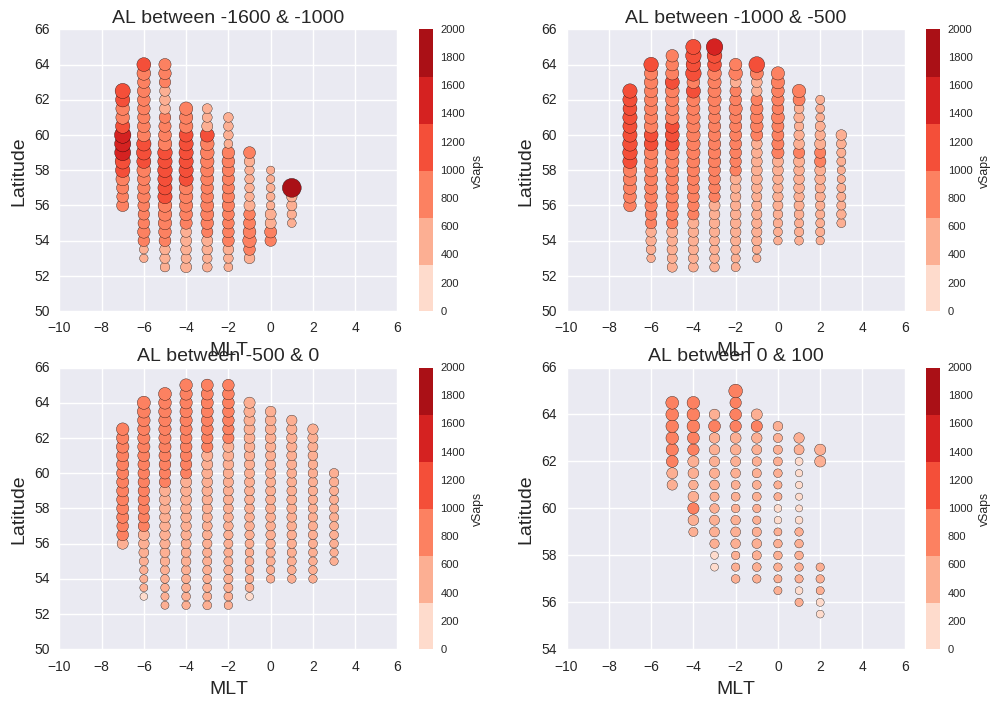

In [12]:
# Groupby AE bin
alLocDF = velGmagDF.groupby( [ "AL_bin", "normMLT", "MLAT" ] ).mean().reset_index()
alLocDF = alLocDF.dropna().reset_index(drop=True)
alLocDF.head()
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,2,1)
ax2 = f.add_subplot(2,2,2)
ax3 = f.add_subplot(2,2,3)
ax4 = f.add_subplot(2,2,4)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (0,250]
alSapsMLTLat0 = alLocDF[ alLocDF["AL_bin"] == "(-1600, -1000]" ]
alSapsMLTLat0.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=alSapsMLTLat0["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "AL between -1600 & -1000", fontsize=14 )
ax1.set_xlim([-10., 6.])
# (250,500]
alSapsMLTLat250 = alLocDF[ alLocDF["AL_bin"] == "(-1000, -500]" ]
alSapsMLTLat250.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=alSapsMLTLat250["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "AL between -1000 & -500", fontsize=14 )
ax2.set_xlim([-10., 6.])
# (500,1000]
alSapsMLTLat500 = alLocDF[ alLocDF["AL_bin"] == "(-500, 0]" ]
alSapsMLTLat500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=alSapsMLTLat500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "AL between -500 & 0", fontsize=14 )
ax3.set_xlim([-10., 6.])
# (1000,1500]
alSapsMLTLat1000 = alLocDF[ alLocDF["AL_bin"] == "(0, 100]" ]
alSapsMLTLat1000.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=alSapsMLTLat1000["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "AL between 0 & 100", fontsize=14 )
ax4.set_xlim([-10., 6.])

plt.savefig("../figs/allALBinsVels.pdf",bbox_inches='tight')